# Computing RS Indices with AWESOME SPECTRAL INDICES

This is a notebook to compute all the indices, that we migh be interested in in our forest project. We use the [Awesome-Spectral-Indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices) module by David Montero Loaiza that makes it very easy to compute the indices (and reference them!). First we need to load our Sentinel-2 dataset and define the standardized band names (and normalize them). Then we put them in a dict, make a list of the indices we want to compute (and a list of the long_name, formula and reference for the attributes). 

In [2]:
import xarray as xr
import os
import fsspec
import matplotlib.pyplot as plt
import numpy as np
import spyndex

path = '/work/users/my982hzao/'


ds_CF_20 = xr.open_zarr(fsspec.get_mapper(path + 'S2_Frankenwald_CF_20.zarr'), \
                  consolidated=True)

A = ds_CF_20.refl.sel(band=1) / 1e5
B = ds_CF_20.refl.sel(band=2) / 1e5
G = ds_CF_20.refl.sel(band=3)/ 1e5
R = ds_CF_20.refl.sel(band=4)/ 1e5
RE1 = ds_CF_20.refl.sel(band=5)/ 1e5
RE2 = ds_CF_20.refl.sel(band=6)/ 1e5
RE3 = ds_CF_20.refl.sel(band=7)/ 1e5
N = ds_CF_20.refl.sel(band=8)/ 1e5
N2 = ds_CF_20.refl.sel(band=9)/ 1e5
WV = ds_CF_20.refl.sel(band=10)/ 1e5
S1 = ds_CF_20.refl.sel(band=11)/ 1e5
S2 = ds_CF_20.refl.sel(band=12)/ 1e5

param_dict = { "A" : A, "B" : B, "G" : G, "R" : R, "RE1" : RE1, "RE2" : RE2, "RE3" : RE3, "N" : N, "N2" : N2, "WV" : WV, "S1" : S1, "S2" : S2, "L" : 0.5, "gamma" : 1, "nexp" : 2,
}
index_list =  ["BI", "BaI", "DSI", "DVI", "GBNDVI", "GDVI", "GLI", "GVMI", "MBI", "MSI", "NDDI", "NDMI", "NDVI", "REDSI", "SAVI", ]
attrs_dict = {}

for index in index_list:
    attrs_dict[str(index)] = str(spyndex.indices[index])


### Performe the index calculation: 

Yes, it's just one line! How great is that? Keep in mind that we're working with a dask array, so the computation is always lazy. It will only compute, if you want to plot the values or call `.compute()` on the array. 

In [3]:
idx = spyndex.computeIndex(
    index = index_list,
    params = param_dict
)

idx.attrs = attrs_dict

In [4]:
idx

<xarray.DataArray 'refl' (index: 15, time: 68, lat: 7530, lon: 11540)>
dask.array<concatenate, shape=(15, 68, 7530, 11540), dtype=float64, chunksize=(1, 1, 471, 1443), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 50.97 50.97 50.97 50.97 ... 50.31 50.31 50.31 50.31
  * lon      (lon) float64 10.29 10.29 10.29 10.29 ... 11.96 11.96 11.96 11.96
  * time     (time) datetime64[ns] 2017-01-22 2017-03-26 ... 2022-12-11
  * index    (index) <U6 'BI' 'BaI' 'DSI' 'DVI' ... 'NDMI' 'NDVI' 'REDSI' 'SAVI'
Attributes: (12/15)
    BI:       BI: Bare Soil Index\n        * Application Domain: soil\n      ...
    BaI:      BaI: Bareness Index\n        * Application Domain: soil\n      ...
    DSI:      DSI: Drought Stress Index\n        * Application Domain: vegeta...
    DVI:      DVI: Difference Vegetation Index\n        * Application Domain:...
    GBNDVI:   GBNDVI: Green-Blue Normalized Difference Vegetation Index\n    ...
    GDVI:     GDVI: Generalized Difference Vegetation Index\n        * Applic...
    ...       ...
    MSI:      MSI: Moisture Stress Index\n        * Application Domain: veget...
    NDDI:     NDDI: Normalized Difference Drought Index\n        * Applicatio...
    NDMI:     NDMI: Normalized Difference Moisture Index\n        * Applicati...
    NDVI:     NDVI: Normalized Difference Vegetation Index\n        * Applica...
    REDSI:    REDSI: Red-Edge Disease Stress Index\n        * Application Dom...
    SAVI:     SAVI: Soil-Adjusted Vegetation Index\n        * Application Dom...

In [5]:
print(idx.attrs['BaI'])

BaI: Bareness Index
        * Application Domain: soil
        * Bands/Parameters: ['R', 'S1', 'N']
        * Formula: R+S1-N
        * Reference: https://doi.org/10.1109/IGARSS.2005.1525743
        


In [16]:
def plot_mean_and_std(ds, color, coords,time_selection=None, ax=None, label=None):


    lat_slice = slice(coords[0] + 0.001, coords[0] - 0.001)
    lon_slice = slice(coords[1] - 0.001, coords[1] + 0.001)

    ds = ds.sel(lat=lat_slice, lon=lon_slice)

    if time_selection:
        ds = ds.isel(time=time_selection)
    if not ax:
        fig, ax = plt.subplots(figsize=(8,5))

    mean = ds.mean(dim = ['lat', 'lon'])
    std = ds.std(dim = ['lat', 'lon'])

    mean.plot(marker = 'o', linestyle='--', linewidth=0.5, markersize = 5, color = color, ax=ax, label=label)
    ax.fill_between(mean.time.values, mean.values+std.values, mean.values-std.values, alpha=0.2, color=color)

    return

In [17]:
def plot_case_study(di, di_reference, coords, color):
    lat_slice = slice(coords[0] + 0.001, coords[0] - 0.001)
    lon_slice = slice(coords[1] - 0.001, coords[1] + 0.001)

    di = di.sel(lat=lat_slice, lon=lon_slice).mean(dim=['lat', 'lon']).isel(time=not_winter)
    di_reference = di_reference.sel(lat=lat_slice, lon=lon_slice).mean()

    (di - di_reference).plot(marker='o', linewidth=1, linestyle='--', color=color)



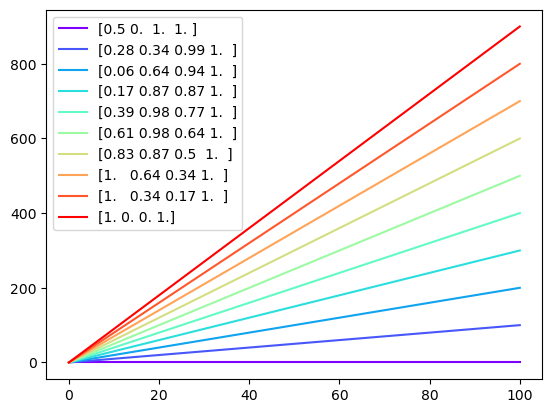

In [18]:
import matplotlib
cmap = matplotlib.cm.get_cmap('rainbow')

colors = cmap(np.linspace(0,1, 10))

colors = np.round(colors, 2)

for i in range(len(colors)):
    plt.plot(np.linspace(0,100), i*np.linspace(0,100), color=colors[i], label=colors[i])

plt.legend()

In [10]:
len(ds_CF_20.time[ds_CF_20.CF < 0.01])

30

## Plot example

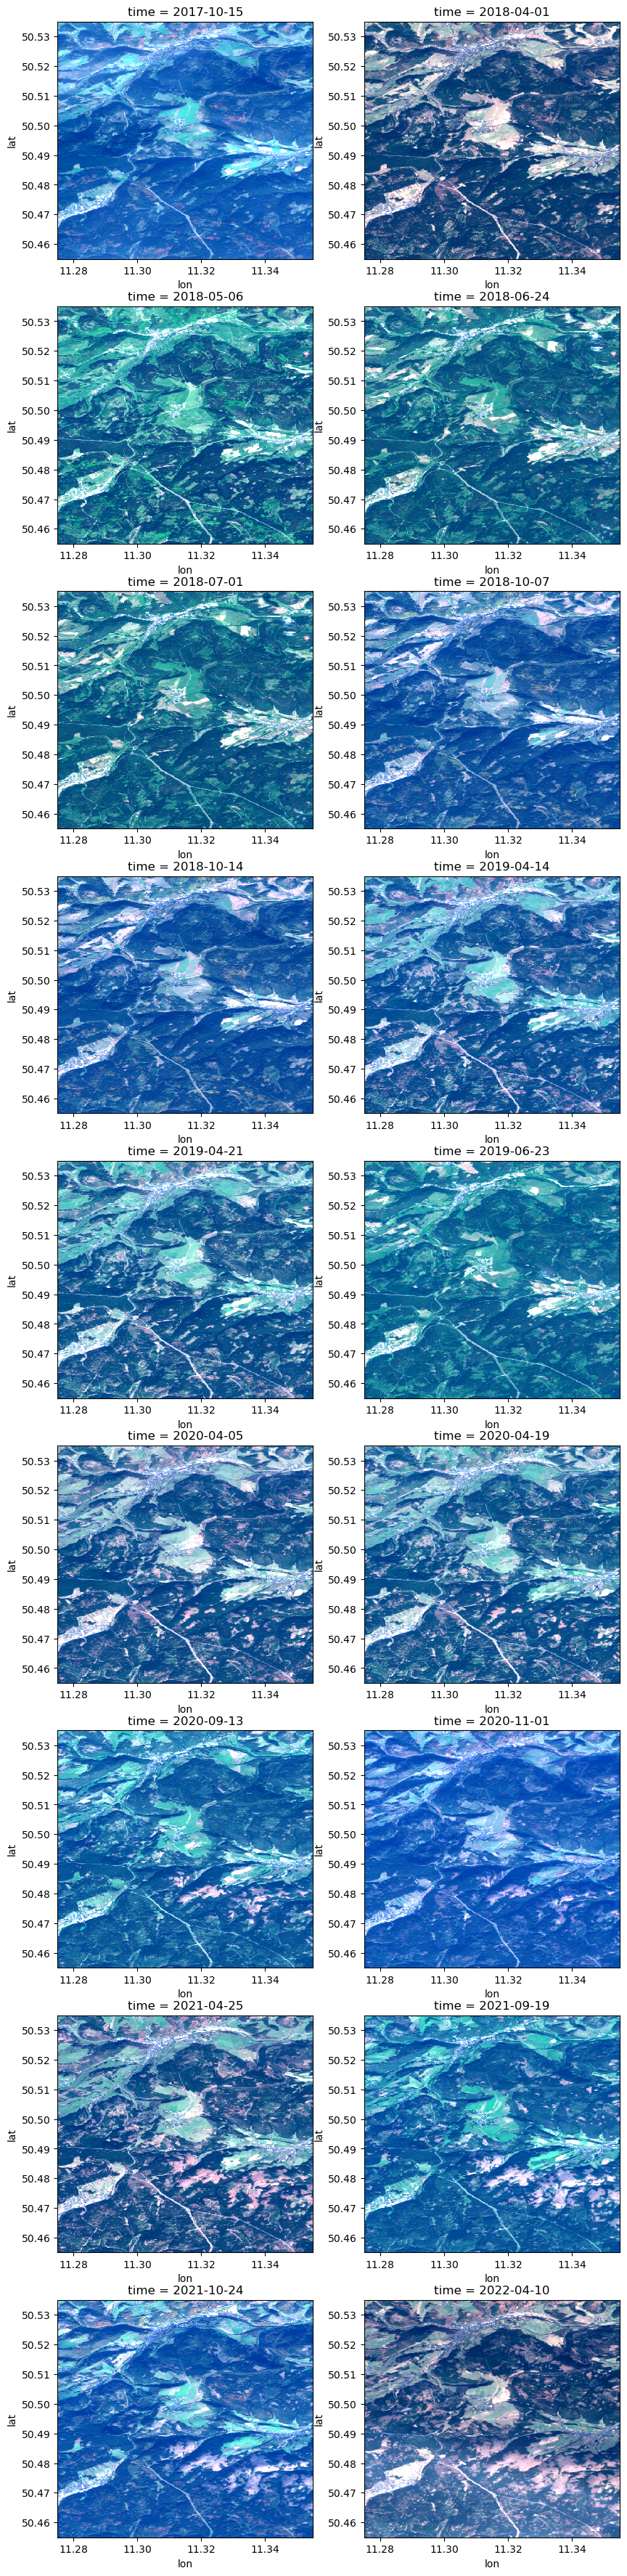

In [14]:
c1 = 50.495, 11.315
c3 = 50.47,  11.30
c2 = 50.48, 11.32

lat_slice = slice(c1[0] + 0.04, c1[0] - 0.04)
lon_slice = slice(c1[1] - 0.04, c1[1] + 0.04)


not_winter = ((ds_CF_20.time.dt.month < 12) & (ds_CF_20.time.dt.month > 3))

selection = (ds_CF_20.CF < 0.01) & (not_winter)


fig, axs = plt.subplots(9, 2, figsize=(2*5, 9*5))
c = 0

for time, ax  in zip(ds_CF_20.time.isel(time=selection), axs.flatten()):
    
    dsf_slice = ds_CF_20.forest_region.sel(lat=lat_slice, lon=lon_slice) 
    

    RGB = (ds_CF_20['refl'].sel(band = [4, 3 ,2]) / 10000 * 3.5 ).sel(time=time, method='nearest')

    RGB.sel(lat=lat_slice, lon=lon_slice).plot.imshow(robust=True, ax= ax)

In [19]:
c2 = 50.48, 11.32
import matplotlib.pyplot as plt

/home/sc.uni-leipzig.de/jn906hluu/.conda/envs/s2_image/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/sc.uni-leipzig.de/jn906hluu/.conda/envs/s2_image/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/sc.uni-leipzig.de/jn906hluu/.conda/envs/s2_image/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/sc.uni-leipzig.de/jn906hluu/.conda/envs/s2_image/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/sc.uni-leipzig.de/jn906hluu/.conda/envs/s2_image/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/sc.uni-leipzig

IndexError: index 10 is out of bounds for axis 0 with size 10

<Figure size 640x480 with 0 Axes>

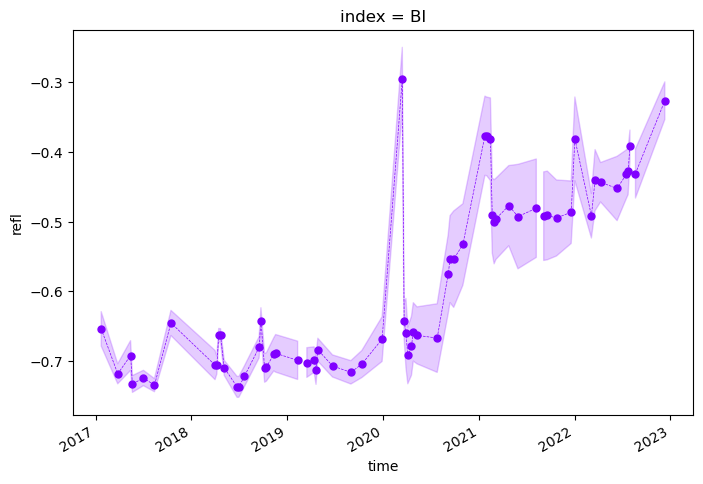

<Figure size 640x480 with 0 Axes>

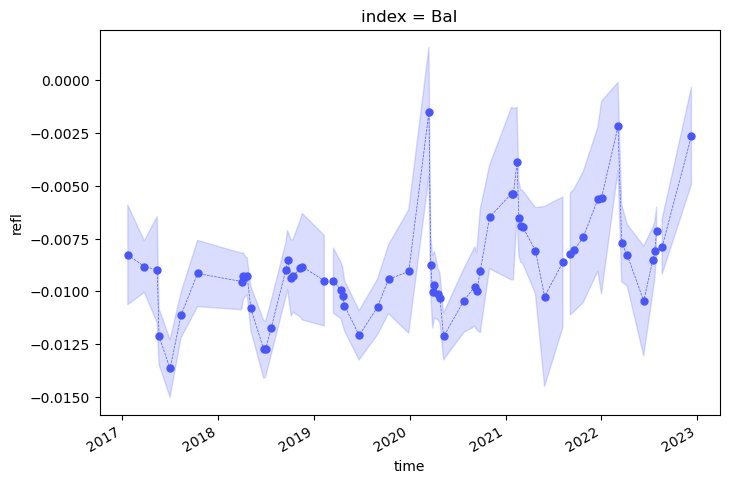

<Figure size 640x480 with 0 Axes>

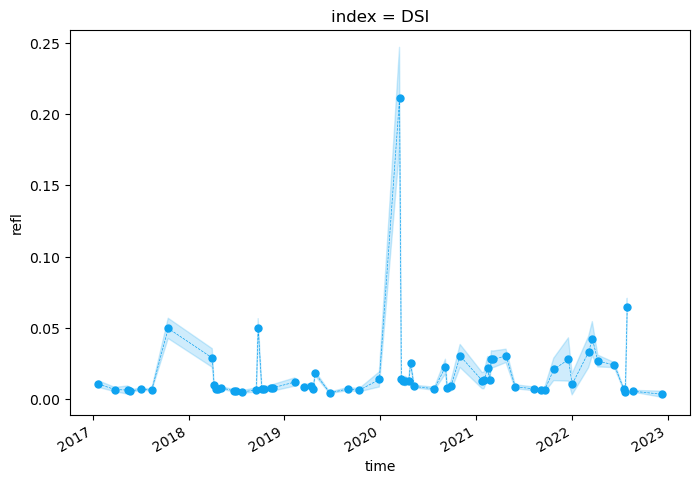

<Figure size 640x480 with 0 Axes>

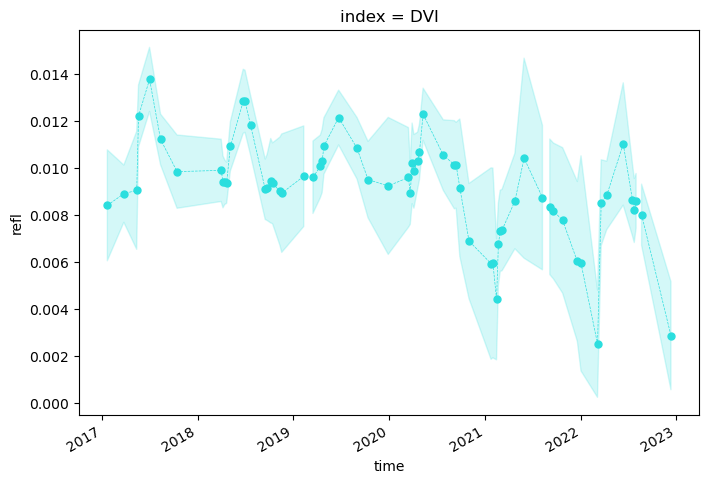

<Figure size 640x480 with 0 Axes>

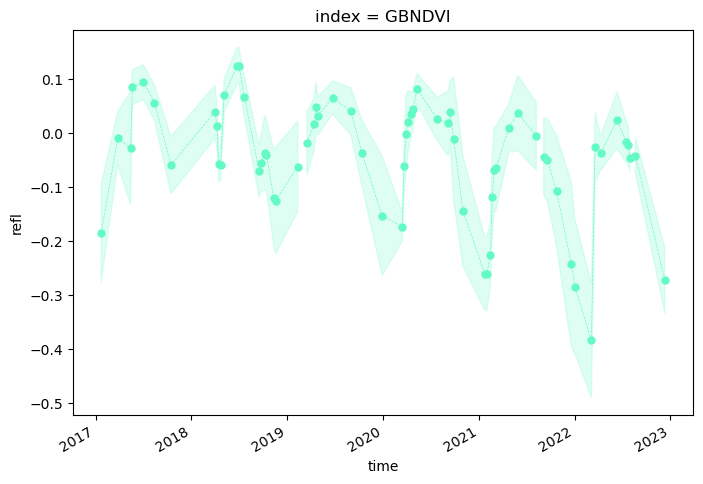

<Figure size 640x480 with 0 Axes>

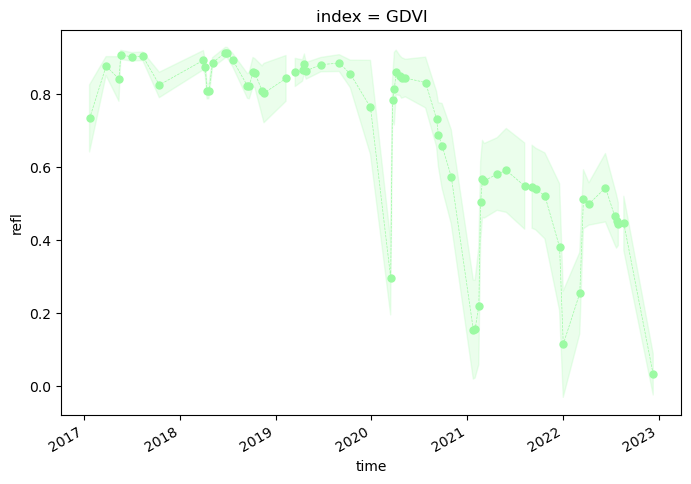

<Figure size 640x480 with 0 Axes>

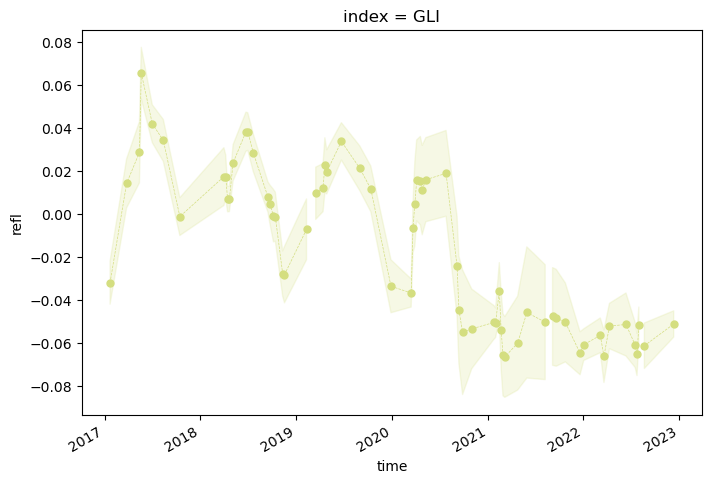

<Figure size 640x480 with 0 Axes>

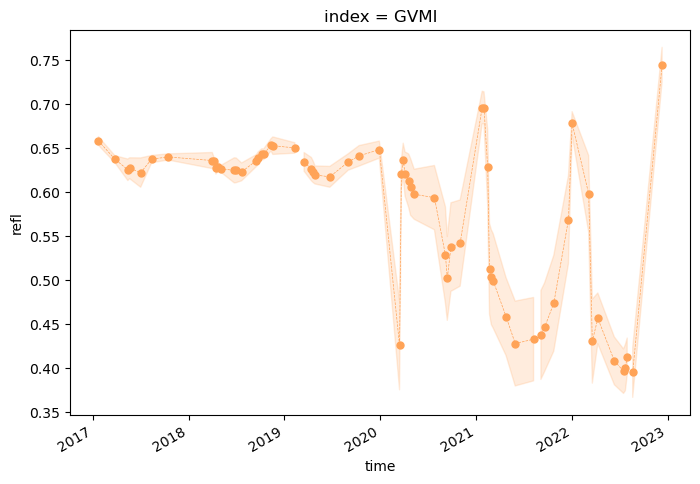

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
for i in range(15):
    plt.figure()
    plot_mean_and_std(idx.isel(index=i), color=colors[i], coords=c2)